# Charge Time Analytics
## Kevin Quigley - x20217366


## Table Of Contents

* [1.Introduction](#into)

* [2.Data Analysis](#anal) 
    
   * [2.1 Weather Dataset](#aveWeather)
   * [2.2 Wind Energy Dataset](#windEnergy)
   * [2.3 Energy Price Dataset](#Eprice)
* [3. Data Modelling](#model)
   * [3.1 Random Forest Model](#forest)

# 0. Readme

The main charge time analytics folder is divded into two sub folders. The first "download" contains the download files needed to scrape data from the three respective data sources. Currently this pulls only historical data and will be updated to pull real time weather data for low electricity price predictions.

metDownload.sh is a bash file which pulls historical data from 8 weather stations across Ireland which provide hourly data on wind direction, precipitation, and wind strength on an hourly basis for the last 5 years. each dataset is pulled, and unzipped into the download folder.


The fileDownloader_*_1.sh scrapes 1 years worth of historical data from the seai dashboard website. Each source for a given month has to be executed seperately, as downloading all at once can crash the remote server. There is other data available for download from the website, but attempting remote download using fileDownloader_*_1.sh causes the SEAI website to crash too. 

The file priceFinder.sh downloads historical price data for a list of times from SEMO using a list of times generated by timeGenerator.py. The range of times can be controlled using the variables set within the timegenerator function. Currently, only the last two months of price data is available from the semo website. So while it cannot currently be used for building models, it can be used to compare results, and confirm that high winds are associated with higher price data from the central operator.

Raw files are then moved individually to the data/ folder to ensure that they are not over-written from an accidental download, which if the SEAI website is down, can result in empty files. After moving the data files, they are joined together using the joiner.py file. This creates a single "weatherMerged" csv file. 

In order to pull this main file from the remote server, the file pullData.sh is used on a local machine. 


## 1. Introduction<a name="into"></a>



The data is pulled from the server by executing "bash data/pullData.sh".
After data is pulled it is then read in as follows:-

### The WeatherMerged dataset

In [94]:
import pandas as pd
import datetime as td
import  numpy as np
weatherMerged = pd.read_csv('data/weatherMerged.csv')


C:\Users\kevin\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (2,3,4,39,41,111,123,131,133,135,136,137,138,139,141,143) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [95]:
weatherMerged.columns

Index(['Date&Time', 'ActualGenerationMW', 'ForecastWind', 'ActualWind',
       'ActualDemand', 'ForecastDemand', 'date2', 'minute', 'ker_ind',
       'ker_rain',
       ...
       'tip_ind.2', 'tip_wetb', 'tip_dewpt', 'tip_vappr', 'tip_rhum',
       'tip_msl', 'tip_ind.3', 'tip_wdsp', 'tip_ind.4', 'tip_wddir'],
      dtype='object', length=144)

In [3]:
weatherMerged= weatherMerged.sort_values(by="date2")
# Just a reminder that the columns available are 'dub_wddir','dub_wdsp','dub_temp','dub_msl'
#'don_wddir','don_wdsp','don_temp','don_msl'
#'cla_wddir','cla_wdsp','cla_temp','cla_msl'
#'cor_wddir','cor_wdsp','cor_temp','cor_msl'

In [4]:
df = weatherMerged

In [5]:
len(weatherMerged)

27748

The above dataset has over 26000 rows and  144 columns.
The central grid columns from SEAI are as follows
- The actual generation represents the total generated capacity in Ireland for a given hour in MW
- The Actual Demand is the total demand on the Irish grid in MW
- ForecastWind is the total forecasted wind power one week ahead for the Irish grid
- ActualWind is the on the spot wind energy being generated for the Irish grid

From Met Eireann for the eight different weather stations we have the columns which are relevant to generation are
- Rain is the total precipitation amount
- Temp is the air temperature
- wetb is the wet bulb temperature
- wdsp is the  mean hourly wind spead in kt
- wddir is the wind direction (from 0-360)
- clamt is the cloud amount (in okta)


Again, the overall goal is to in real time calculate the cheapest time to charge an electric vehicle. This time will be both optimized for the grid operator and the consumer.

### The ePrice dataset

The Irish Single Electric Market Operator group(SEMO) controls the price of electricity. A diagram showing their contribution is shown below:-


![title](img/SEMOsystem.jpg)

The Imbalance Settlement Price is the price in EUR per Megawatt Hour (MWh), meaning the cost of energy actions taken by the TSO to balance demand and supply in a 30 minute trading period. (PIMB)

The Net Imbalance Volume is the amount of energy needed to balance the system, this can be positive or negative indicating if the system is long or short for generation required in a 30 minute trading period. (NIV (MWh))

In [6]:
ePrice = pd.read_csv('data/ePrice.csv')
ePrice.columns= ['StartTime', 'EndTime', 'NetImbalanceVolume','ImbalanceSettlementPrice']
ePrice


,StartTime,EndTime,NetImbalanceVolume,ImbalanceSettlementPrice
0,2022-05-27T00:00:00,\t2022-05-27T00:30:00,-29.291,74.45
1,2022-05-27T00:30:00,\t2022-05-27T01:00:00,-23.329,82.32
2,2022-05-27T01:00:00,\t2022-05-27T01:30:00,-36.292,52.02
3,2022-05-27T01:30:00,\t2022-05-27T02:00:00,-42.894,-107.00
4,2022-05-27T02:00:00,\t2022-05-27T02:30:00,-33.407,43.87
...,...,...,...,...
1103,2022-07-01T21:30:00,\t2022-07-01T22:00:00,15.843,222.43
1104,2022-07-01T22:00:00,\t2022-07-01T22:30:00,32.151,150.85
1105,2022-07-01T22:30:00,\t2022-07-01T23:00:00,24.988,147.63
1106,2022-07-01T23:00:00,\t2022-07-01T23:30:00,30.974,146.90


![title](img/imbvImage.png)

## 2. Data Analysis <a name="anal"></a>


### 2.1 Average Weather conditions <a name="aveWeather"></a>


1. Looking at average weather conditions in the various stations we have the following

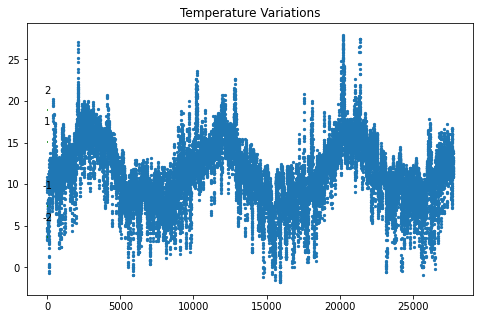

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.title("Temperature Variations") # Title
#plt.ylim(-40,40) # Setting y limits
plt.scatter(x=df.index, y=df['ker_temp'], s=5); # Plotting scatter


plt.hlines(y=df['ker_temp'].mean(), xmin=0, xmax=max(df["ker_temp"])) # Mean


for std_int in [-2, -1, 1, 2]: # Going through different stds from the mean
    standard_deviation = df['ker_temp'].mean() + df['ker_temp'].std()*std_int
    
    plt.hlines(y=standard_deviation,
               xmin=0,
               xmax=max(df["ker_temp"]),
               linestyles='dashed',
               colors='green'); # 1 std above
    
    # Giving labels to the lines we just drew
    plt.text(y=standard_deviation + 2, x=-10, s=std_int, ha='center')

In [8]:
df  = weatherMerged

In [9]:
df.loc[df['tip_temp']==' ']= np.nan 

In [10]:
df = weatherMerged
data_1 = df['dub_temp']
data_2 = df['cor_temp']
data_3 = df['ker_temp']
data_4 = df['tip_temp']
data_5 = df['may_temp']
data_6 = df['sli_temp']
data_7 = df['don_temp']
data = [data_1, data_2, data_3, data_4,data_5,data_6,data_7]

In [11]:
try:
    data_4.astype('float')
    print("All Good")
except ValueError:
        print("Something wrong with the types!")
#return("Something wrong with the types")

All Good


In [12]:
for i in range(len(data_4)):
    try:
        s = np.array(data_4[i],dtype = np.float)
    except ValueError:
        print("The value is",data_4[i],". The number is",i )
        print()

In [13]:
df = df.drop(['tip_temp'], axis = 1)
data_4 = weatherMerged['tip_temp']
data_4_i = []
def conv(s):
    try:
        s=float(s)
    except ValueError:
        pass    
    return s
for i in data_4:
    j=conv(i)
    data_4_i.append(j)
#xtra = {'tip_temp': data_4_i}
#df = df.append(pd.DataFrame(xtra))

df['tip_temp']= np.array(data_4_i, dtype=np.float) 

In [14]:
data_4 = df['tip_temp']
print(len(data_4))
print(len(data_4_i))
print(type(data_4_i[0]))
print(type(data_4[0]))

27748
27748
<class 'float'>
<class 'numpy.float64'>


In [15]:
# Checking the types
print(type(data_1[0]))
print(type(data_2[0]))
print(type(data_3[0]))
print(type(data_4[0]))
print(type(data_5[0]))
print(type(data_6[0]))
print(type(data_7[0]))

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>


In [16]:
import numpy as np 
df=df.replace('', np.nan, regex=True)
df = df.dropna()

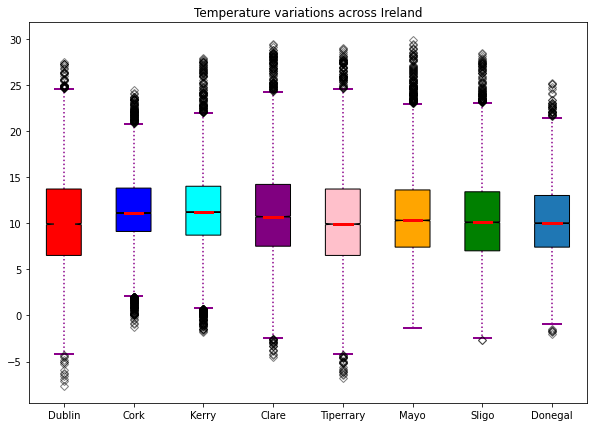

In [17]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
 
# Creating dataset
np.random.seed(10)
data_1 = df['dub_temp']
data_2 = df['cor_temp']
data_3 = df['ker_temp']
data_4 = df['cla_temp']
data_5 = df['tip_temp']
data_6 = df['may_temp']
data_7 = df['sli_temp']
data_8 = df['don_temp']
data = [data_1, data_2, data_3, data_4,data_5,data_6,data_7,data_8]
 
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
 
# Creating axes instance
bp = ax.boxplot(data, patch_artist = True,
                notch ='True', vert = 1)
 
colors = ['red','blue','cyan','purple','pink','orange','green']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)
 
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
 
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
# x-axis labels
ax.set_xticklabels(['Dublin', 'Cork',
                    'Kerry', 'Clare',
                    'Tiperrary', 'Mayo',
                    'Sligo','Donegal'])

 
# Adding title
plt.title("Temperature variations across Ireland")
 
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
     
# show plot
plt.show()

In [18]:
df = weatherMerged

In [19]:

data_1 = df['dub_wdsp']
data_2 = df['cor_wdsp']
data_3 = df['ker_wdsp']
data_4 = df['cla_wdsp']
data_5 = df['tip_wdsp']
data_6 = df['may_wdsp']
data_7 = df['sli_wdsp']
data_8 = df['don_wdsp']

In [20]:
# Checking the types
print(type(data_1[0]))
print(type(data_2[0]))
print(type(data_3[0]))
print(type(data_4[0]))
print(type(data_5[0]))
print(type(data_6[0]))
print(type(data_7[0]))
print(type(data_8[0]))

<class 'int'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'str'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>


In [21]:
for i in range(len(data_1)):
    try:
        s = np.array(data_1[i],dtype = np.float)
    except ValueError:
        print("The value is",data_1[i],". The number is",i )
        print()
        
df.loc[df['dub_wdsp']==' ']= np.nan 

The value is   . The number is 10018

The value is   . The number is 10019

The value is   . The number is 10020

The value is   . The number is 10021



In [22]:

df.loc[df['tip_wdsp']=='   ']= np.nan
df.loc[df['tip_wdsp']=='  ']= np.nan 
df.loc[df['tip_wdsp']==' ']= np.nan 
df.loc[df['tip_wdsp']=='']= np.nan 

for i in range(len(data_5)):
    try:
        s = np.array(data_5[i],dtype = np.float)
    except ValueError:
        print("The value is",data_5[i],". The number is",i )
        print()
        
df.loc[df['tip_wdsp']==' ']= np.nan 

In [23]:
df = df.drop(['dub_wdsp'], axis = 1)
data_1 = weatherMerged['dub_wdsp']
data_1_i = []
def conv(s):
    try:
        s=float(s)
    except ValueError:
        pass    
    return s
for i in data_1:
    j=conv(i)
    data_1_i.append(j)
#xtra = {'tip_temp': data_4_i}
#df = df.append(pd.DataFrame(xtra))

df['dub_wdsp']= np.array(data_1_i, dtype=np.float) 

In [24]:
df = df.drop(['tip_wdsp'], axis = 1)
data_5 = weatherMerged['tip_wdsp']
data_5_i = []
def conv(s):
    try:
        s=float(s)
    except ValueError:
        pass    
    return s
for i in data_5:
    j=conv(i)
    data_5_i.append(j)
#xtra = {'tip_temp': data_4_i}
#df = df.append(pd.DataFrame(xtra))

df['tip_wdsp']= np.array(data_5_i, dtype=np.float) 

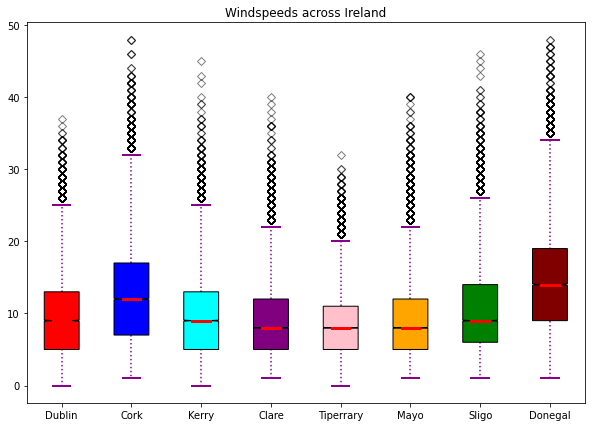

In [25]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
 
# Creating dataset
np.random.seed(10)
data_1 = df['dub_wdsp']
data_2 = df['cor_wdsp']
data_3 = df['ker_wdsp']
data_4 = df['cla_wdsp']
data_5 = df['tip_wdsp']
data_6 = df['may_wdsp']
data_7 = df['sli_wdsp']
data_8 = df['don_wdsp']

data1 = data_1.to_numpy()
data2 = data_2.to_numpy()
data3 = data_3.to_numpy()
data4 = data_4.to_numpy()
data5 = data_5.to_numpy()
data6 = data_6.to_numpy()
data7 = data_7.to_numpy()
data8 = data_8.to_numpy()


data1 = data1[~np.isnan(data1)] 
data2 = data2[~np.isnan(data2)] 
data3 = data3[~np.isnan(data3)] 
data4 = data4[~np.isnan(data4)] 
data5 = data5[~np.isnan(data5)] 
data6 = data6[~np.isnan(data6)] 
data7 = data7[~np.isnan(data7)] 
data8 = data8[~np.isnan(data8)] 

data = [data1, data2, data3, data4,data5,data6,data7,data8]


#data = [data_1, data_2, data_3, data_4,data_5,data_6,data_7,data_8]
 
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
 
# Creating axes instance
bp = ax.boxplot(data, patch_artist = True,
                notch ='True', vert = 1)
 
colors = ['red','blue','cyan','purple','pink','orange','green','maroon']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)
 
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
 
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
# x-axis labels
ax.set_xticklabels(['Dublin', 'Cork',
                    'Kerry', 'Clare',
                    'Tiperrary', 'Mayo',
                    'Sligo','Donegal'])

 
# Adding title
plt.title("Windspeeds across Ireland")
 
# Removing top axes and right axes

# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
     
# show plot
plt.show()

In [26]:
df = weatherMerged

In [27]:
data_1 = df['dub_wddir']
data_2 = df['cor_wddir']
data_3 = df['ker_wddir']
data_4 = df['cla_wddir']
data_5 = df['tip_wddir']
data_6 = df['may_wddir']
data_7 = df['sli_wddir']
data_8 = df['don_wddir']
data = [data_1, data_2, data_3, data_4,data_5,data_6,data_7,data_8]

print(type(data_1[0]))
print(type(data_2[0]))
print(type(data_3[0]))
print(type(data_4[0]))
print(type(data_5[0]))
print(type(data_6[0]))
print(type(data_7[0]))
print(type(data_8[0]))

<class 'int'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'str'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'int'>


In [28]:
for i in range(len(data_1)):
    try:
        s = np.array(data_1[i],dtype = np.float)
    except ValueError:
        print("The value is",data_1[i],". The number is",i )
        print()
    except KeyError: 
        print("The value is",data_1[i],". The number is",i )
        print()

for i in range(len(data_1)):
    try:
        s = np.array(data_1[i],dtype = np.float)
    except ValueError:
        print("The value is",data_1[i],". The number is",i )
        print()
        
df.loc[df['dub_wddir']==' ']= np.nan 

df = df.drop(['dub_wddir'], axis = 1)
data_1 = weatherMerged['dub_wddir']
data_1_i = []


def conv(s):
    try:
        s=float(s)
    except ValueError:
        pass    
    return s
for i in data_1:
    j=conv(i)
    data_1_i.append(j)
#xtra = {'tip_temp': data_4_i}
#df = df.append(pd.DataFrame(xtra))

df['dub_wddir']= np.array(data_1_i, dtype=np.float) 

In [29]:
for i in range(len(data_5)):
    try:
        s = np.array(data_5[i],dtype = np.float)
    except ValueError:
        print("The value is",data_5[i],". The number is",i )
        print()
    except KeyError: 
        print("The value is",data_5[i],". The number is",i )
        print()

for i in range(len(data_5)):
    try:
        s = np.array(data_5[i],dtype = np.float)
    except ValueError:
        print("The value is",data_5[i],". The number is",i )
        print()

df.loc[df['tip_wddir']=='   ']= np.nan
df.loc[df['tip_wddir']=='  ']= np.nan 
df.loc[df['tip_wddir']==' ']= np.nan 
df.loc[df['tip_wddir']=='']= np.nan 
df = df.drop(['tip_wddir'], axis = 1)
data_5 = weatherMerged['tip_wddir']
data_5_i = []


def conv(s):
    try:
        s=float(s)
    except ValueError:
        pass    
    return s
for i in data_5:
    j=conv(i)
    data_5_i.append(j)
#xtra = {'tip_temp': data_4_i}
#df = df.append(pd.DataFrame(xtra))

df['tip_wddir']= np.array(data_5_i, dtype=np.float) 

In [30]:
for i in range(len(data_8)):
    try:
        s = np.array(data_8[i],dtype = np.float)
    except ValueError:
        print("The value is",data_8[i],". The number is",i )
        print()
    except KeyError: 
        print("The value is",data_8[i],". The number is",i )
        print()

for i in range(len(data_8)):
    try:
        s = np.array(data_8[i],dtype = np.float)
    except ValueError:
        print("The value is",data_8[i],". The number is",i )
        print()

df.loc[df['don_wddir']=='   ']= np.nan
df.loc[df['don_wddir']=='  ']= np.nan 
df.loc[df['don_wddir']==' ']= np.nan 
df.loc[df['don_wddir']=='']= np.nan 
df = df.drop(['don_wddir'], axis = 1)
data_8 = weatherMerged['don_wddir']
data_8_i = []


def conv(s):
    try:
        s=float(s)
    except ValueError:
        pass    
    return s
for i in data_5:
    j=conv(i)
    data_8_i.append(j)
#xtra = {'tip_temp': data_4_i}
#df = df.append(pd.DataFrame(xtra))

df['don_wddir']= np.array(data_8_i, dtype=np.float) 

The value is   . The number is 14711

The value is   . The number is 18738

The value is   . The number is 14711

The value is   . The number is 18738



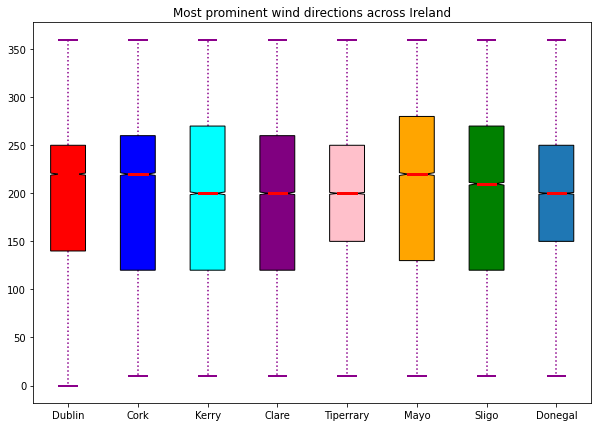

In [31]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
 
# Creating dataset
np.random.seed(10)
data_1 = df['dub_wddir']
data_2 = df['cor_wddir']
data_3 = df['ker_wddir']
data_4 = df['cla_wddir']
data_5 = df['tip_wddir']
data_6 = df['may_wddir']
data_7 = df['sli_wddir']
data_8 = df['don_wddir']

data1 = data_1.to_numpy()
data2 = data_2.to_numpy()
data3 = data_3.to_numpy()
data4 = data_4.to_numpy()
data5 = data_5.to_numpy()
data6 = data_6.to_numpy()
data7 = data_7.to_numpy()
data8 = data_8.to_numpy()


data1 = data1[~np.isnan(data1)] 
data2 = data2[~np.isnan(data2)] 
data3 = data3[~np.isnan(data3)] 
data4 = data4[~np.isnan(data4)] 
data5 = data5[~np.isnan(data5)] 
data6 = data6[~np.isnan(data6)] 
data7 = data7[~np.isnan(data7)] 
data8 = data8[~np.isnan(data8)] 

data = [data1, data2, data3, data4,data5,data6,data7,data8]

#data = [data_1, data_2, data_3, data_4,data_5,data_6,data_7,data_8]
 
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
 
# Creating axes instance
bp = ax.boxplot(data, patch_artist = True,
                notch ='True', vert = 1)
 
colors = ['red','blue','cyan','purple','pink','orange','green']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)
 
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
 
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
# x-axis labels
ax.set_xticklabels(['Dublin', 'Cork',
                    'Kerry', 'Clare',
                    'Tiperrary', 'Mayo',
                    'Sligo','Donegal'])

 
# Adding title
plt.title("Most prominent wind directions across Ireland")
 
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
     
# show plot
plt.show()

### Wind Energy Dataset <a name="windEnergy"></a>

#### Total Wind Energy Produced


In [32]:
import pandas as pd
import datetime as td
weatherMerged = pd.read_csv('data/weatherMerged.csv')
df = weatherMerged

C:\Users\kevin\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (2,3,4,39,41,111,123,131,133,135,136,137,138,139,141,143) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [33]:

data_1 = df['ActualGenerationMW']
data_2 = df['ForecastWind']
data_3 = df['ActualWind']
data_4 = df['ActualDemand']
#data_4 = df['ForecastDemand']

print(type(data_1[0]))
print(type(data_2[0]))
print(type(data_3[0]))
print(type(data_4[0]))
#print(type(data_5[0]))

data = [data_1,data_2,data_3,data_4]

<class 'numpy.float64'>
<class 'int'>
<class 'str'>
<class 'str'>


In [34]:
'''for i in range(len(data_2)):
    try:
        s = np.array(data_2[i],dtype = np.float)
    except ValueError:
        print("The value is",data_2[i],". The number is",i )
        print()
    except KeyError: 
        print("The value is",data_2[i],". The number is",i )
        print()

for i in range(len(data_2)):
    try:
        s = np.array(data_2[i],dtype = np.float)
    except ValueError:
        print("The value is",data_2[i],". The number is",i )
        print()
  '''      
df.loc[df['ForecastWind']=='   ']= np.nan
df.loc[df['ForecastWind']=='  ']= np.nan 
df.loc[df['ForecastWind']==' ']= np.nan 
df.loc[df['ForecastWind']=='- ']= np.nan
df.loc[df['ForecastWind']=='-']= np.nan
df.loc[df['ForecastWind']==' - ']= np.nan
df.loc[df['ForecastWind']==' -']= np.nan 
df.loc[df['ForecastWind']=='']= np.nan 

df.loc[df['ActualWind']=='   ']= np.nan
df.loc[df['ActualWind']=='  ']= np.nan 
df.loc[df['ActualWind']==' ']= np.nan 
df.loc[df['ActualWind']=='- ']= np.nan
df.loc[df['ActualWind']=='-']= np.nan 
df.loc[df['ActualWind']==' -']= np.nan 
df.loc[df['ActualWind']=='']= np.nan 

df = df.drop(['ActualWind'], axis = 1)
data_3 = weatherMerged['ActualWind']
data_3_i = []
df = df.drop(['ForecastWind'], axis = 1)
data_2 = weatherMerged['ForecastWind']
data_2_i = []


def conv(s):
    try:
        s=float(s)
    except ValueError:
        pass    
    return s
for i in data_2:
    j=conv(i)
    data_2_i.append(j)

def conv(s):
    try:
        s=float(s)
    except ValueError:
        pass    
    return s
for i in data_3:
    j=conv(i)
    data_3_i.append(j)
    
#print(data_2_i)
df['ForecastWind']= np.array(data_2_i, dtype=np.float) 
df['ActualWind']= np.array(data_3_i, dtype=np.float) 

In [35]:
'''for i in range(len(data_5)):
    try:
        s = np.array(data_5[i],dtype = np.float)
    except ValueError:
        print("The value is",data_5[i],". The number is",i )
        print()
    except KeyError: 
        print("The value is",data_5[i],". The number is",i )
        print()

for i in range(len(data_5)):
    try:
        s = np.array(data_5[i],dtype = np.float)
    except ValueError:
        print("The value is",data_5[i],". The number is",i )
        print()
'''
df.loc[df['ActualDemand']=='   ']= np.nan
df.loc[df['ActualDemand']=='  ']= np.nan 
df.loc[df['ActualDemand']==' ']= np.nan 
df.loc[df['ActualDemand']=='- ']= np.nan
df.loc[df['ActualDemand']=='-']= np.nan 
df.loc[df['ActualDemand']=='']= np.nan 
df = df.drop(['ActualDemand'], axis = 1)
data_4 = weatherMerged['ActualDemand']
data_4_i = []


def conv(s):
    try:
        s=float(s)
    except ValueError:
        pass    
    return s
for i in data_4:
    j=conv(i)
    data_4_i.append(j)

df['ActualDemand']= np.array(data_4_i, dtype=np.float) 

In [36]:
df = df.dropna(subset = ['ActualGenerationMW','ForecastWind','ActualWind','ActualDemand'])

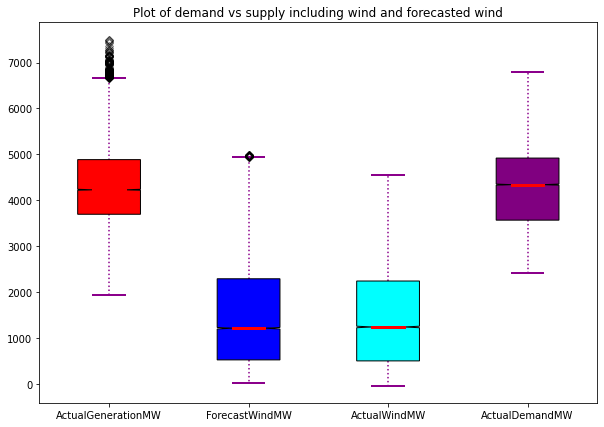

In [37]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
 
# Creating dataset
np.random.seed(10)
data_1 = df['ActualGenerationMW']
data_2 = df['ForecastWind']
data_3 = df['ActualWind']
data_4 = df['ActualDemand']

data1 = data_1.to_numpy()
data2 = data_2.to_numpy()
data3 = data_3.to_numpy()
data4 = data_4.to_numpy()

data1 = data1[~np.isnan(data1)] 
data2 = data2[~np.isnan(data2)] 
data3 = data3[~np.isnan(data3)] 
data4 = data4[~np.isnan(data4)] 
data = [data1, data2, data3, data4]
 
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
 
# Creating axes instance
bp = ax.boxplot(data, patch_artist = True,
                notch ='True')
 
colors = ['red','blue','cyan','purple','pink']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)
 
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
 
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
# x-axis labels
ax.set_xticklabels(['ActualGenerationMW', 'ForecastWindMW',
                    'ActualWindMW','ActualDemandMW'])

# Adding title
plt.title("Plot of demand vs supply including wind and forecasted wind")
 
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
     
# show plot
plt.show()

In [38]:
df['date2']

0        2019-04-01 00:00:00
1        2019-04-01 01:00:00
2        2019-04-01 02:00:00
3        2019-04-01 03:00:00
4        2019-04-01 04:00:00
                ...         
27743    2022-05-31 20:00:00
27744    2022-05-31 21:00:00
27745    2022-05-31 22:00:00
27746    2022-05-31 23:00:00
27747    2022-06-01 00:00:00
Name: date2, Length: 27714, dtype: object

## Using Fourier Transforms to extract important time periodicities

In [39]:
## Creating a subset dataframe
df['date2'] =  pd.to_datetime(df['date2'])
df1 = df[['date2',"ActualGenerationMW","ForecastWind","ActualWind","ActualDemand",'dub_wddir','dub_wdsp','dub_temp','dub_msl','don_wddir','don_wdsp','don_temp','don_msl','cla_wddir','cla_wdsp','cla_temp','cla_msl','cor_wddir','cor_wdsp','cor_temp','cor_msl']]


weatherMerged= weatherMerged.sort_values(by="date2")
# Just a reminder that the columns available are 'dub_wddir','dub_wdsp','dub_temp','dub_msl'
#'don_wddir','don_wdsp','don_temp','don_msl'
#'cla_wddir','cla_wdsp','cla_temp','cla_msl'
#'cor_wddir','cor_wdsp','cor_temp','cor_msl'

df1['hour']=df1['date2'].dt.hour
df1['dayOfWeek']=df1['date2'].dt.day_of_week
df1['dayOfYear']=df1['date2'].dt.day_of_year
df1=df1.dropna()

C:\Users\kevin\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


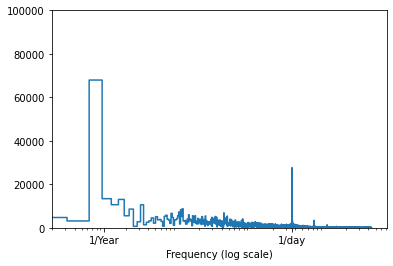

In [40]:
sum_col = df1['dayOfYear'][0]+(df1['hour']/24)
df1=df1._convert(numeric=True)

import tensorflow as tf
fft = tf.signal.rfft(df1['dub_temp'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df1['dub_temp'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 100000)
#plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

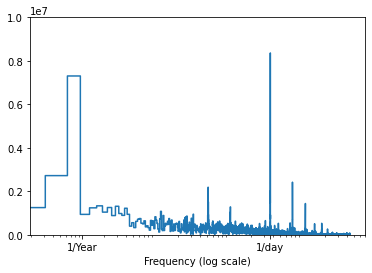

In [41]:
import tensorflow as tf
fft = tf.signal.rfft(df1['ActualGenerationMW'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df1['ActualGenerationMW'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 10000000)
#plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

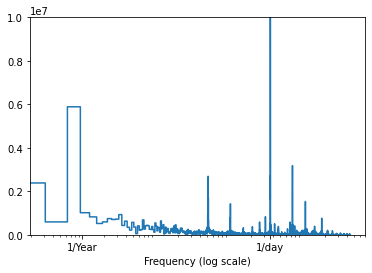

In [42]:
import tensorflow as tf
fft = tf.signal.rfft(df1['ActualDemand'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df1['ActualDemand'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 10000000)
#plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

## Transforming Columns

In [43]:
import math as ma
df1["sin_hour"]=np.sin(df1["hour"]/24*2*ma.pi)
df1["sin_day"]=np.sin(df1["dayOfYear"]/365*(2*ma.pi))


df1["cos_hour"]=np.sin(df1["hour"]/24*2*ma.pi)
df1["cos_day"]=np.sin(df1["dayOfYear"]/365*(2*ma.pi))

![title](img/timeRotation.png)
![title](img/timeCalc.png)

'[title]' is not recognized as an internal or external command,
operable program or batch file.
'[title]' is not recognized as an internal or external command,
operable program or batch file.


### Constructing a vector from the periodic time-series data
Above we see that the wind direction is shown in degrees. This is not an ideal format for the direction to be entered as a variable for numerical modelling as 360° and 0° are equal, and so the model should warp around.

Secondly, wind direction is found to have a negatory effect if windspeed is high, (See there opposite assication with generation shown in the diagram above). Therefore creating a wind vector which is a combination of the two would be optimal

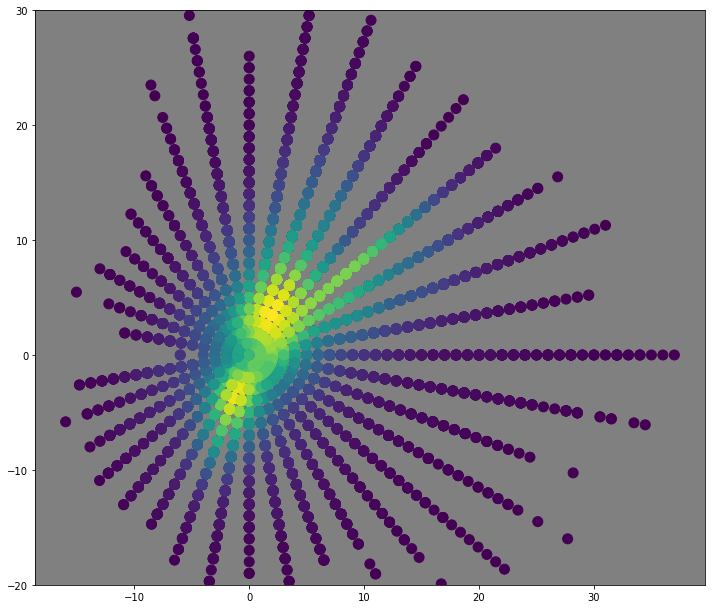

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

df1=df1._convert(numeric=True)
# Generate fake data
df1 = df1[df1['dub_wdsp'].notna()]
df1 = df1[df1['dub_wddir'].notna()]


df1["sin_dub_wddir"]=np.sin((df1["dub_wddir"]-180)/360*2*ma.pi)
df1["cos_dub_wddir"]=np.cos((df1["dub_wddir"]-180)/360*2*ma.pi)


x = df1["dub_wdsp"]*df1["cos_dub_wddir"]
y = df1["dub_wdsp"]*df1["sin_dub_wddir"]




# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
ax. set_aspect('equal')
ax.set_facecolor('grey')
fig.set_size_inches(12, 12)
plt.ylim(-20,30)
plt.show()

In [45]:
# New column creation

#Dublin
df1["sin_dub_wddir"]=np.sin((df1["dub_wddir"]-180)/360*2*ma.pi)
df1["cos_dub_wddir"]=np.cos((df1["dub_wddir"]-180)/360*2*ma.pi)
#Cork
df1["sin_cor_wddir"]=np.sin((df1["cor_wddir"]-180)/360*2*ma.pi)
df1["cos_cor_wddir"]=np.cos((df1["cor_wddir"]-180)/360*2*ma.pi)
#Clare
df1["sin_cla_wddir"]=np.sin((df1["cla_wddir"]-180)/360*2*ma.pi)
df1["cos_cla_wddir"]=np.cos((df1["cla_wddir"]-180)/360*2*ma.pi)
#Donegal
df1["sin_don_wddir"]=np.sin((df1["don_wddir"]-180)/360*2*ma.pi)
df1["cos_don_wddir"]=np.cos((df1["don_wddir"]-180)/360*2*ma.pi)





#Dublin
df1['cos_dub_vec'] = df1["dub_wdsp"]*np.sin((df1["dub_wddir"]-180)/360*2*ma.pi)
df1['sin_dub_vec'] = df1["dub_wdsp"]*np.cos((df1["dub_wddir"]-180)/360*2*ma.pi)

#Cork
df1['cos_cor_vec'] = df1["cor_wdsp"]*np.sin((df1["cor_wddir"]-180)/360*2*ma.pi)
df1['sin_cor_vec'] = df1["cor_wdsp"]*np.cos((df1["cor_wddir"]-180)/360*2*ma.pi)

#Clare
df1['cos_cla_vec'] = df1["cla_wdsp"]*np.sin((df1["cla_wddir"]-180)/360*2*ma.pi)
df1['sin_cla_vec'] = df1["cla_wdsp"]*np.cos((df1["cla_wddir"]-180)/360*2*ma.pi)

#Donegal
df1['cos_don_vec'] = df1["don_wdsp"]*np.sin((df1["don_wddir"]-180)/360*2*ma.pi)
df1['sin_don_vec'] = df1["don_wdsp"]*np.cos((df1["don_wddir"]-180)/360*2*ma.pi)


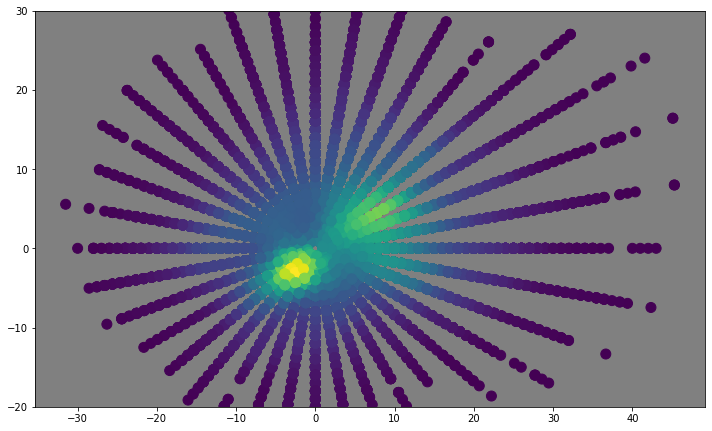

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

df1=df1._convert(numeric=True)
# Generate fake data

x =df1['cos_cor_vec']
y = df1['sin_cor_vec']




# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
ax. set_aspect('equal')
ax.set_facecolor('grey')
fig.set_size_inches(12, 12)
plt.ylim(-20,30)
plt.show()

## Measuring Colinearity

Many of the columns can be linearly independent, and we now search for eigenvectors in the dataframe.

In [47]:
corr = df1.corr()
corr.style.background_gradient(cmap='coolwarm')

,ActualGenerationMW,ForecastWind,ActualWind,ActualDemand,dub_wddir,dub_wdsp,dub_temp,dub_msl,don_wddir,don_wdsp,don_temp,don_msl,cla_wddir,cla_wdsp,cla_temp,cla_msl,cor_wddir,cor_wdsp,cor_temp,cor_msl,hour,dayOfWeek,dayOfYear,sin_hour,sin_day,cos_hour,cos_day,sin_dub_wddir,cos_dub_wddir,sin_cor_wddir,cos_cor_wddir,sin_cla_wddir,cos_cla_wddir,sin_don_wddir,cos_don_wddir,cos_dub_vec,sin_dub_vec,cos_cor_vec,sin_cor_vec,cos_cla_vec,sin_cla_vec,cos_don_vec,sin_don_vec
ActualGenerationMW,1.000000,0.522627,0.594881,0.796103,0.047305,0.410255,-0.127270,-0.157075,-0.008990,0.396773,-0.192241,-0.199757,0.065853,0.440292,-0.126457,-0.155364,0.154996,0.438615,-0.156869,-0.131566,0.425246,-0.145300,-0.046884,-0.433668,0.042200,-0.433668,0.042200,0.046698,0.092498,0.123228,0.147640,0.056872,0.149437,0.015489,0.103323,0.139291,0.241444,0.169701,0.173308,0.110733,0.207944,0.055155,0.143946
ForecastWind,0.522627,1.000000,0.953096,0.128089,0.102419,0.793659,-0.134501,-0.402026,0.027594,0.716696,-0.174665,-0.489617,0.111202,0.779798,-0.139230,-0.397376,0.258762,0.780929,-0.140822,-0.348358,0.012719,0.017321,-0.070869,-0.022622,0.077595,-0.022622,0.077595,0.103840,0.259906,0.266773,0.225045,0.123237,0.266137,0.062373,0.201010,0.307775,0.543165,0.384089,0.345665,0.222765,0.429220,0.140676,0.285506
ActualWind,0.594881,0.953096,1.000000,0.195716,0.085917,0.757931,-0.126442,-0.368319,0.013872,0.707468,-0.165721,-0.449482,0.098102,0.755912,-0.134231,-0.366206,0.249606,0.746952,-0.134346,-0.322301,0.063086,-0.007666,-0.069685,-0.078344,0.070952,-0.078344,0.070952,0.087620,0.250291,0.251828,0.232764,0.104749,0.265391,0.050478,0.205705,0.286022,0.504171,0.344280,0.331718,0.191329,0.404220,0.125833,0.274790
ActualDemand,0.796103,0.128089,0.195716,1.000000,0.043129,0.156049,-0.058057,-0.044235,0.009600,0.136719,-0.136779,-0.055697,0.053094,0.155059,-0.056929,-0.036432,0.091621,0.144116,-0.107526,-0.026099,0.601349,-0.177213,-0.046749,-0.603516,0.036940,-0.603516,0.036940,0.048552,-0.017928,0.060623,0.080153,0.058054,0.067635,0.034573,-0.016164,0.064786,0.046670,0.065703,0.048159,0.080949,0.058931,0.048246,0.019089
dub_wddir,0.047305,0.102419,0.085917,0.043129,1.000000,0.184903,-0.088114,-0.109006,0.507832,0.188214,-0.024212,-0.189950,0.458698,0.066996,-0.127630,-0.020283,0.423982,-0.013624,-0.088567,0.037458,-0.014632,-0.014205,0.042401,0.013553,-0.101871,0.013553,-0.101871,0.890699,0.291310,0.470406,-0.037538,0.472197,0.124898,0.574936,-0.061991,0.722952,0.251417,0.466219,-0.017687,0.464926,0.110497,0.533124,-0.080454
dub_wdsp,0.410255,0.793659,0.757931,0.156049,0.184903,1.000000,0.031620,-0.399656,0.117919,0.639835,-0.036748,-0.500898,0.163210,0.690374,0.006003,-0.368350,0.299839,0.635538,-0.017552,-0.301755,0.038358,0.012018,-0.063879,-0.056274,0.028187,-0.056274,0.028187,0.243062,0.325302,0.394144,0.266787,0.275414,0.339225,0.222923,0.160474,0.476467,0.657294,0.494139,0.351162,0.379577,0.462023,0.295525,0.281237
dub_temp,-0.127270,-0.134501,-0.126442,-0.058057,-0.088114,0.031620,1.000000,0.038067,-0.077407,-0.193653,0.879814,0.056479,0.038819,0.106332,0.935696,0.022609,0.041107,-0.055651,0.893883,0.034487,0.157470,-0.011798,0.197002,-0.196062,-0.286397,-0.196062,-0.286397,-0.098457,-0.066008,0.068698,0.339857,0.063250,0.173280,-0.054487,0.014292,-0.047952,0.022184,-0.000798,0.252781,0.036586,0.163135,-0.055335,0.093969
dub_msl,-0.157075,-0.402026,-0.368319,-0.044235,-0.109006,-0.399656,0.038067,1.000000,0.032817,-0.294882,0.092809,0.976171,-0.197159,-0.406401,0.067086,0.984991,-0.370146,-0.460666,0.018612,0.966101,0.001800,-0.024820,-0.183648,0.001451,0.140744,0.001451,0.140744,-0.117854,-0.153497,-0.404951,-0.108320,-0.220744,-0.146811,0.050478,-0.042081,-0.225709,-0.308972,-0.502238,-0.163734,-0.284237,-0.199909,0.036536,-0.065610
don_wddir,-0.008990,0.027594,0.013872,0.009600,0.507832,0.117919,-0.077407,0.032817,1.000000,0.119290,-0.017866,-0.042992,0.353363,-0.022299,-0.094215,0.110208,0.286101,-0.089297,-0.062758,0.151376,-0.008016,-0.041394,0.026

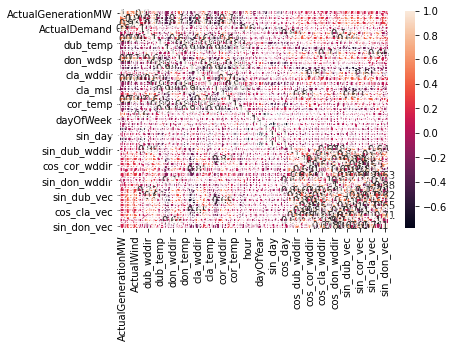

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
hm = sns.heatmap(df1.corr(), annot = True)
#hm.set(xlabel='\nIRIS Flower Details', ylabel='IRIS Flower Details\t', title = "Correlation matrix of IRIS data\n")
corr.style.background_gradient(cmap='coolwarm')
plt.show()

### Producing correlation graphs for specific combinations of weather cols

C:\Users\kevin\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


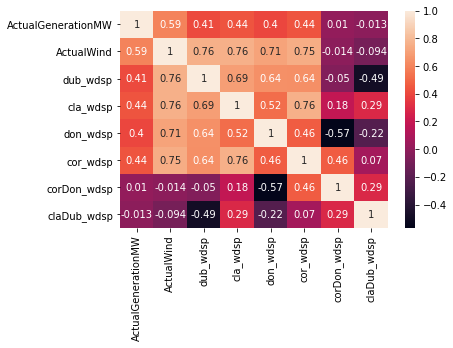

In [49]:
df=df._convert(numeric=True)
dfWind= df[["ActualGenerationMW","ActualWind",'dub_wdsp','cla_wdsp','don_wdsp','cor_wdsp']]
dfWind["corDon_wdsp"]= dfWind['cor_wdsp']-dfWind['don_wdsp']
dfWind["claDub_wdsp"]= dfWind['cla_wdsp']-dfWind['dub_wdsp']
hm = sns.heatmap(dfWind.corr(), annot = True)
#hm.set(xlabel='\nIRIS Flower Details', ylabel='IRIS Flower Details\t', title = "Correlation matrix of IRIS data\n")
corr.style.background_gradient(cmap='coolwarm')
plt.show()

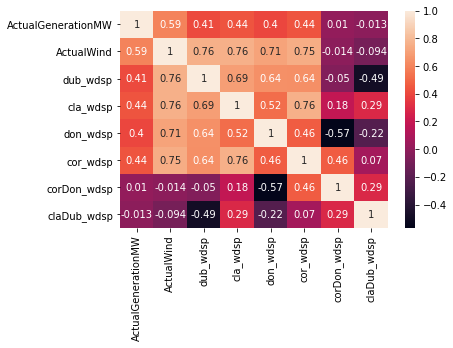

In [50]:
dfWind= df1[["ActualGenerationMW","ActualWind",'dub_wdsp','cla_wdsp','don_wdsp','cor_wdsp']]
dfWind["corDon_wdsp"]= dfWind['cor_wdsp']-dfWind['don_wdsp']
dfWind["claDub_wdsp"]= dfWind['cla_wdsp']-dfWind['dub_wdsp']
hm = sns.heatmap(dfWind.corr(), annot = True)
#hm.set(xlabel='\nIRIS Flower Details', ylabel='IRIS Flower Details\t', title = "Correlation matrix of IRIS data\n")
corr.style.background_gradient(cmap='coolwarm')
plt.show()


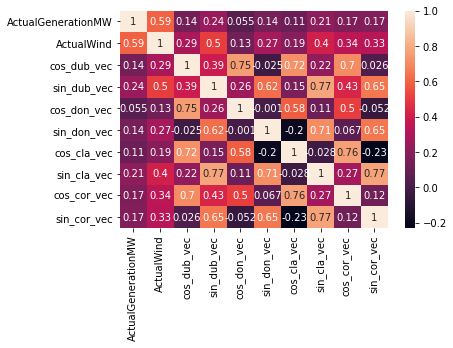

In [51]:

dfVec= df1[["ActualGenerationMW","ActualWind",'cos_dub_vec','sin_dub_vec','cos_don_vec','sin_don_vec','cos_cla_vec','sin_cla_vec','cos_cor_vec','sin_cor_vec']]

hm = sns.heatmap(dfVec.corr(), annot = True)
#hm.set(xlabel='\nIRIS Flower Details', ylabel='IRIS Flower Details\t', title = "Correlation matrix of IRIS data\n")
corr.style.background_gradient(cmap='coolwarm')
plt.show()

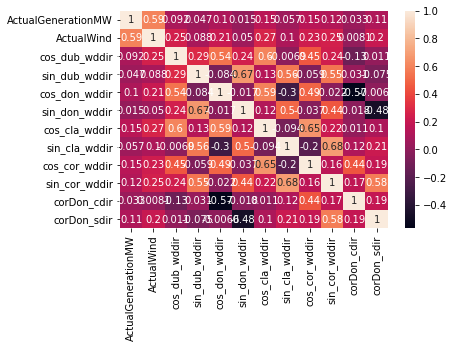

In [52]:

dfVec= df1[["ActualGenerationMW","ActualWind",'cos_dub_wddir','sin_dub_wddir','cos_don_wddir','sin_don_wddir','cos_cla_wddir','sin_cla_wddir','cos_cor_wddir','sin_cor_wddir']]
dfVec["corDon_cdir"]= dfVec['cos_cor_wddir']-dfVec['cos_don_wddir']
dfVec["corDon_sdir"]= dfVec['sin_cor_wddir']-dfVec['sin_don_wddir']

hm = sns.heatmap(dfVec.corr(), annot = True)
#hm.set(xlabel='\nIRIS Flower Details', ylabel='IRIS Flower Details\t', title = "Correlation matrix of IRIS data\n")
corr.style.background_gradient(cmap='coolwarm')
plt.show()

### investigating variance invlation factor 

In [53]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import add_constant
add_constant(df)

C:\Users\kevin\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,Date&Time,ActualGenerationMW,ForecastDemand,date2,minute,ker_ind,ker_rain,ker_ind.1,ker_temp,ker_ind.2,...,tip_vappr,tip_rhum,tip_msl,tip_ind.3,tip_wdsp,tip_ind.4,tip_wddir,ForecastWind,ActualWind,ActualDemand
0,1 April 2019 00:00,2681.0,-,2019-04-01 00:00:00,0.0,0.0,0.0,0.0,6.3,0.0,...,7.7,88.0,1024.0,2.0,3.0,2.0,130.0,273.0,555.0,3430.0
1,1 April 2019 01:00,2696.0,-,2019-04-01 01:00:00,0.0,0.0,0.0,0.0,4.6,0.0,...,6.6,89.0,1023.8,2.0,2.0,2.0,140.0,241.0,470.0,3281.0
2,1 April 2019 02:00,2834.0,-,2019-04-01 02:00:00,0.0,0.0,0.0,0.0,4.8,0.0,...,6.7,92.0,1023.2,2.0,3.0,2.0,160.0,222.0,372.0,3149.0
3,1 April 2019 03:00,2886.0,-,2019-04-01 03:00:00,0.0,0.0,0.0,0.0,3.7,0.0,...,6.5,92.0,1022.4,2.0,3.0,2.0,150.0,225.0,342.0,3073.0
4,1 April 2019 04:00,2891.0,-,2019-04-01 04:00:00,0.0,0.0,0.0,0.0,3.3,0.0,...,7.5,95.0,1021.6,2.0,3.0,2.0,180.0,253.0,342.0,3024.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27743,31 May 2022 20:00,4845.0,-,2022-05-31 20:00:00,0.0,0.0,0.0,0.0,11.8,0.0,...,9.8,73.0,1016.2,2.0,8.0,2.0,300.0,749.0,670.0,4830.0
27744,31 May 2022 21:00,4815.0,-,2022-05-31 21:00:00,0.0,0.0,0.0,0.0,11.5,0.0,...,10.1,82.0,1016.9,2.0,6.0,2.0,280.0,682.0,578.0,4661.0
27745,31 May 2022 22:00,4614.0,-,2022-05-31 22:00:00,0.0,0.0,0.0,0.0,11.8,0.0,...,10.1,81.0,1017.2,2.0,5.0,2.0,270.0,587.0,546.0,4465.0
27746,31 May 2022 23:00,4205.0,-,2022-05-31 23:00:00,0.0,0.0,0.0,0.0,11.7,0.0,...,9.9,80.0,1017.2,2.0,5.0,2.0,280.0,563.0,464.0,4101.0


### Energy Prices Dataset <a name="ePrice"></a>

In [54]:
import pandas as pd
import numpy as np
import datetime as dt

In [55]:
ePrice = pd.read_csv('data/ePrice.csv')
ePrice.columns= ['StartTime', 'EndTime', 'NetImbalanceVolume','ImbalanceSettlementPrice']
ePrice


,StartTime,EndTime,NetImbalanceVolume,ImbalanceSettlementPrice
0,2022-05-27T00:00:00,\t2022-05-27T00:30:00,-29.291,74.45
1,2022-05-27T00:30:00,\t2022-05-27T01:00:00,-23.329,82.32
2,2022-05-27T01:00:00,\t2022-05-27T01:30:00,-36.292,52.02
3,2022-05-27T01:30:00,\t2022-05-27T02:00:00,-42.894,-107.00
4,2022-05-27T02:00:00,\t2022-05-27T02:30:00,-33.407,43.87
...,...,...,...,...
1103,2022-07-01T21:30:00,\t2022-07-01T22:00:00,15.843,222.43
1104,2022-07-01T22:00:00,\t2022-07-01T22:30:00,32.151,150.85
1105,2022-07-01T22:30:00,\t2022-07-01T23:00:00,24.988,147.63
1106,2022-07-01T23:00:00,\t2022-07-01T23:30:00,30.974,146.90


In [56]:
ePrice = pd.read_csv('data/ePrice.csv')
ePrice=ePrice._convert(numeric=True)
ePrice.columns= ['StartTime', 'EndTime', 'NetImbalanceVolume','ImbalanceSettlementPrice']
ePrice = ePrice[ePrice['NetImbalanceVolume'].notna()]
ePrice = ePrice[ePrice['ImbalanceSettlementPrice'].notna()]


In [57]:
#Below commnand fails as the starttime is outside the bounds of the first dataset
'''ePrice['date2'] = [dt.datetime.strptime(d,"%Y-%m-%dT%H:%M:%S") for d in ePrice["StartTime"] ]
ePrice['minute'] = ePrice['date2'].dt.minute
ePrice = ePrice[ePrice['minute'] == 0]
weatherPrice = pd.merge(ePrice,weatherMerged, on = 'date2')
'''


'ePrice[\'date2\'] = [dt.datetime.strptime(d,"%Y-%m-%dT%H:%M:%S") for d in ePrice["StartTime"] ]\nePrice[\'minute\'] = ePrice[\'date2\'].dt.minute\nePrice = ePrice[ePrice[\'minute\'] == 0]\nweatherPrice = pd.merge(ePrice,weatherMerged, on = \'date2\')\n'

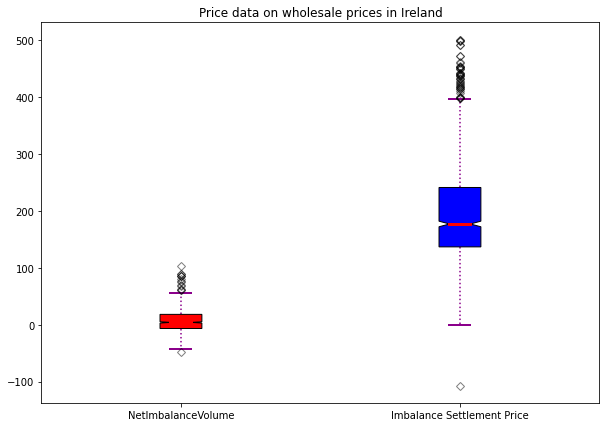

In [58]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
 
# Creating dataset
np.random.seed(10)
data_1 = ePrice['NetImbalanceVolume']
data_2 = ePrice['ImbalanceSettlementPrice']
data = [data_1, data_2]
 
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
 
# Creating axes instance
bp = ax.boxplot(data, patch_artist = True,
                notch ='True', vert = 1)
 
colors = ['red','blue']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)
 
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
 
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
# x-axis labels
ax.set_xticklabels(['NetImbalanceVolume', 'Imbalance Settlement Price'])

 
# Adding title
plt.title("Price data on wholesale prices in Ireland")
 
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
     
# show plot
plt.show()

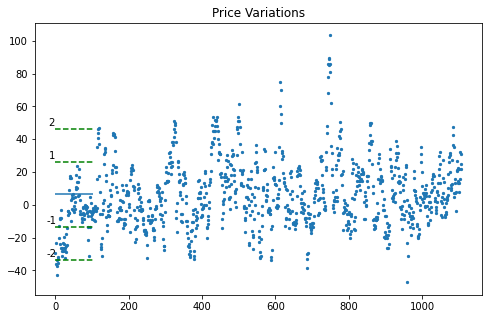

In [59]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.title("Price Variations") # Title
#plt.ylim(-40,40) # Setting y limits
plt.scatter(x=ePrice.index, y=ePrice['NetImbalanceVolume'], s=5); # Plotting scatter


plt.hlines(y=ePrice['NetImbalanceVolume'].mean(), xmin=0, xmax=max(ePrice['NetImbalanceVolume'])) # Mean


for std_int in [-2, -1, 1, 2]: # Going through different stds from the mean
    standard_deviation = ePrice['NetImbalanceVolume'].mean() + ePrice['NetImbalanceVolume'].std()*std_int
    
    plt.hlines(y=standard_deviation,
               xmin=0,
               xmax=max(ePrice['NetImbalanceVolume']),
               linestyles='dashed',
               colors='green'); # 1 std above
    
    # Giving labels to the lines we just drew
    plt.text(y=standard_deviation + 2, x=-10, s=std_int, ha='center')

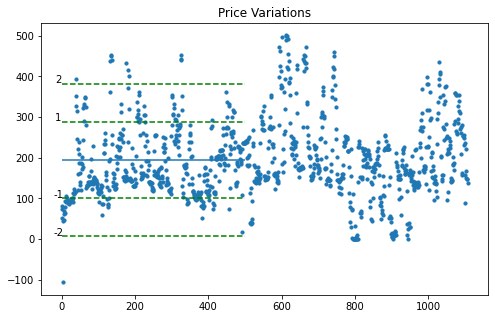

In [60]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.title("Price Variations") # Title
#plt.ylim(-40,40) # Setting y limits
plt.scatter(x=ePrice.index, y=ePrice['ImbalanceSettlementPrice'], s=10); # Plotting scatter


plt.hlines(y=ePrice['ImbalanceSettlementPrice'].mean(), xmin=0, xmax=max(ePrice['ImbalanceSettlementPrice'])) # Mean


for std_int in [-2, -1, 1, 2]: # Going through different stds from the mean
    standard_deviation = ePrice['ImbalanceSettlementPrice'].mean() + ePrice['ImbalanceSettlementPrice'].std()*std_int
    
    plt.hlines(y=standard_deviation,
               xmin=0,
               xmax=max(ePrice['ImbalanceSettlementPrice']),
               linestyles='dashed',
               colors='green'); # 1 std above
    
    # Giving labels to the lines we just drew
    plt.text(y=standard_deviation + 2, x=-10, s=std_int, ha='center')

### Corelations between settlement price and wind generation

Columns are given by Index(['date2', 'EndTime', 'NetImbalanceVolume', 'ImbalanceSettlementPrice',
       'ActualGenerationMW', 'ForecastWind', 'ActualWind', 'ActualDemand',
       'dub_wddir', 'dub_wdsp', 'dub_temp', 'dub_msl', 'don_wddir', 'don_wdsp',
       'don_temp', 'don_msl', 'cla_wddir', 'cla_wdsp', 'cla_temp', 'cla_msl',
       'cor_wddir', 'cor_wdsp', 'cor_temp', 'cor_msl', 'hour', 'dayOfWeek',
       'dayOfYear', 'sin_hour', 'sin_day', 'cos_hour', 'cos_day',
       'sin_dub_wddir', 'cos_dub_wddir', 'sin_cor_wddir', 'cos_cor_wddir',
       'sin_cla_wddir', 'cos_cla_wddir', 'sin_don_wddir', 'cos_don_wddir',
       'cos_dub_vec', 'sin_dub_vec', 'cos_cor_vec', 'sin_cor_vec',
       'cos_cla_vec', 'sin_cla_vec', 'cos_don_vec', 'sin_don_vec', 'year',
       'month', 'totalImbalance', 'totalImbalancep', 'imbalanceAverage',
       'imbalanceVar', 'imbalanceVarAvg'],
      dtype='object')
Correlation Co-efficient is given by [[ 1.         -0.37374837]
 [-0.37374837  1.        ]]


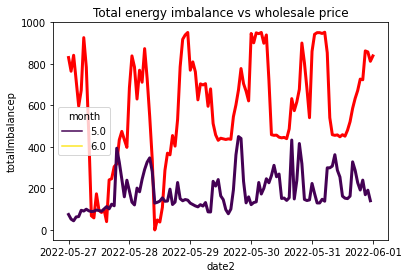

In [61]:
df1['dayOfWeek']= df1['date2'].dt.day_of_week
df1['year']= df1['date2'].dt.year
df1['month']= df1['date2'].dt.month


df1['totalImbalance']= df1['ActualGenerationMW']-df1['ActualDemand']
df1['totalImbalancep']=df1['totalImbalance']-min(df1['totalImbalance'])


df1['imbalanceAverage'] = df1.totalImbalance.rolling(window=24*14).mean()
df1['imbalanceVar']=df1.totalImbalance.rolling(24).var()
df1['imbalanceVarAvg'] = df1.imbalanceVar.rolling(window=24*14).mean()

ePrice.columns = ['date2','EndTime','NetImbalanceVolume','ImbalanceSettlementPrice']
ePrice['date2'] =  pd.to_datetime(ePrice['date2'])
ePriceDF=pd.merge(df1,ePrice, how='inner', left_index=True, right_index=True)
ePriceDF=pd.merge(ePrice, df1, how='outer', on='date2')
#Pretty small number of columns, need to get more data, hopefully next month get's pushed soon
ePriceDF=ePriceDF.dropna()
print("Columns are given by",ePriceDF.columns)
corcoef= np.corrcoef(ePriceDF['ImbalanceSettlementPrice'], ePriceDF['imbalanceVarAvg'])
print("Correlation Co-efficient is given by",corcoef)
ePriceDF['totalImbalancep']=ePriceDF['totalImbalance']-min(ePriceDF['totalImbalance'])




ax = sns.lineplot(data=ePriceDF, x ='date2', y = 'totalImbalancep', color = 'red',
                  legend='full', lw=3)

ax = sns.lineplot(data=ePriceDF, x ='date2', y = 'ImbalanceSettlementPrice',
                  hue='month', palette='viridis',
                  legend='full', lw=3)


np.corrcoef(ePriceDF['ImbalanceSettlementPrice'], ePriceDF['totalImbalancep'])
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())
#plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0, 6, 12, 18]))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0 ]))
plt.title('Total energy imbalance vs wholesale price')
#plt.gcf().autofmt_xdate()
plt.show()

C:\Users\kevin\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


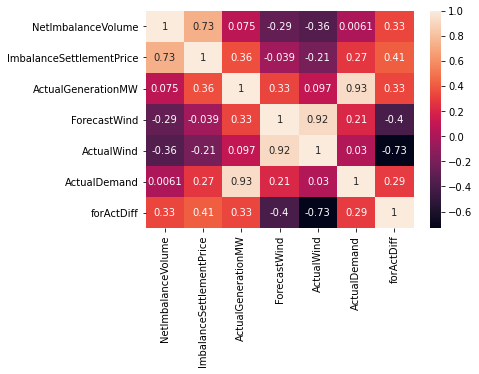

In [62]:

ePriceDFCorr = ePriceDF[['NetImbalanceVolume', 'ImbalanceSettlementPrice','ActualGenerationMW', 'ForecastWind', 'ActualWind', 'ActualDemand']]
ePriceDFCorr["forActDiff"]= ePriceDFCorr['ForecastWind']-ePriceDFCorr['ActualWind']

hm = sns.heatmap(ePriceDFCorr.corr(), annot = True)
#hm.set(xlabel='\nIRIS Flower Details', ylabel='IRIS Flower Details\t', title = "Correlation matrix of IRIS data\n")
corr.style.background_gradient(cmap='coolwarm')
plt.show()

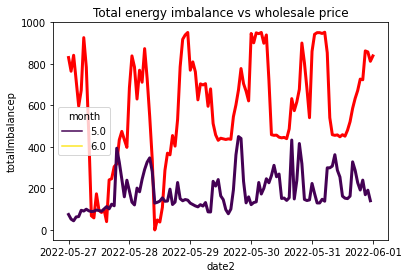

In [63]:
ax = sns.lineplot(data=ePriceDF, x ='date2', y = 'totalImbalancep', color = 'red',
                  legend='full', lw=3)

ax = sns.lineplot(data=ePriceDF, x ='date2', y = 'ImbalanceSettlementPrice',
                  hue='month', palette='viridis',
                  legend='full', lw=3)

#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())
#plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0, 6, 12, 18]))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0 ]))
plt.title('Total energy imbalance vs wholesale price')
#plt.gcf().autofmt_xdate()
plt.show()

### Creating further plots and visualizations

Text(0.5, 1.0, 'Actual Wind generation (MW)')

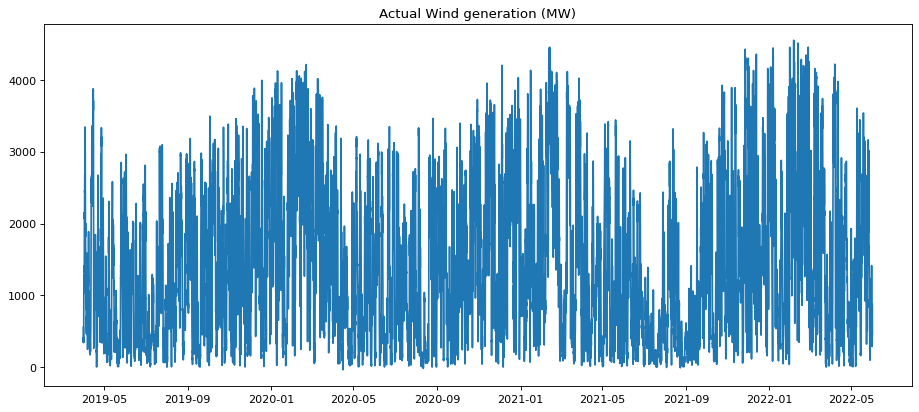

In [64]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.dates as md
from matplotlib.pyplot import figure

figure(figsize=(14, 6), dpi=80)
tail=df1.tail(24*7)
y=df1['ActualWind']
x=df1['date2']


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.plot(x,y)
plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0, 6, 12, 18]))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0 ]))
plt.title('Actual Wind generation (MW)')
#plt.gcf().autofmt_xdate()

## Creating ML Models <a name="model"></a>

Next we discuss the predictive variable.

There are a variety of variables which can be controlled for to give the optimal charging time.The one which we have chosen is predicting the maximum difference between actual consumption and generation for a given week

Shown below is the total capacity , and the points where renewable generation exceeds 70% of total. at the points highlighted, batteries could be charged for later discharge. The goal is to convey this information to public and industrial users so they can modify their behaviour accordingly. 

![title](img/windForecast.png)

### Total Imbalance variable


In [65]:
 df1['date2'] = pd.DatetimeIndex(df1['date2'])

In [66]:
type( df1['date2'] )

pandas.core.series.Series

In [67]:
df1['hour']

0         0
1         1
2         2
3         3
4         4
         ..
27743    20
27744    21
27745    22
27746    23
27747     0
Name: hour, Length: 27710, dtype: int64

C:\Users\kevin\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


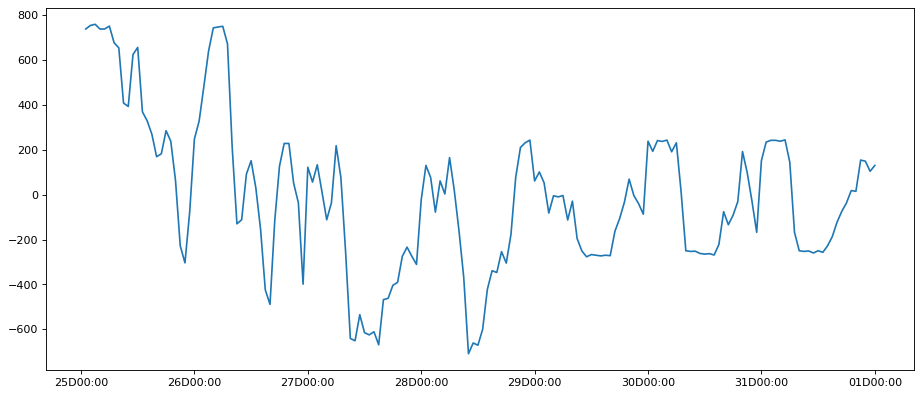

In [68]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.dates as md
from matplotlib.pyplot import figure

figure(figsize=(14, 6), dpi=80)
tail=df1.tail(24*7)
x = tail['date2']
y = tail['totalImbalance'] = tail['ActualGenerationMW']-tail['ActualDemand']

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.plot(x,y)
plt.gca().xaxis.set_major_formatter(md.DateFormatter('%dD%H:%M'))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0, 6, 12, 18]))
plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0 ]))

#plt.gcf().autofmt_xdate()

In the peaks of the graph shown above, electricity should be cheapest

In [69]:
df1['totalImbalance'] = df1['ActualGenerationMW']-df1['ActualDemand']

In [70]:
print(df1.to_csv('data/chargeML.csv', index=False))


None


## Investigating energy usage change after Ukrainian war

Creating new column, date of year

In [71]:
df1[df1['dayOfYear']==1]

,date2,ActualGenerationMW,ForecastWind,ActualWind,ActualDemand,dub_wddir,dub_wdsp,dub_temp,dub_msl,don_wddir,...,sin_cla_vec,cos_don_vec,sin_don_vec,year,month,totalImbalance,totalImbalancep,imbalanceAverage,imbalanceVar,imbalanceVarAvg
6601,2020-01-01 00:00:00,3534.0,553.0,591.0,3778.0,220.0,4.0,5.9,1030.2,190.0,...,1.710101,2.431074,13.787309,2020,1,-244.0,863.0,71.119048,447835.239130,220928.960770
6602,2020-01-01 01:00:00,3589.0,598.0,575.0,3603.0,230.0,6.0,6.2,1029.8,200.0,...,0.868241,4.446262,12.216004,2020,1,-14.0,1093.0,70.517857,395909.188406,221623.503472
6603,2020-01-01 02:00:00,3485.0,639.0,656.0,3395.0,210.0,5.0,5.9,1029.5,190.0,...,3.000000,1.910130,10.832885,2020,1,90.0,1197.0,69.116071,357840.085145,222066.195760
6604,2020-01-01 03:00:00,3330.0,700.0,809.0,3163.0,140.0,6.0,4.6,1028.6,200.0,...,2.500000,3.762222,10.336619,2020,1,167.0,1274.0,67.443452,344538.717391,222267.044427
6605,2020-01-01 04:00:00,3233.0,690.0,858.0,3066.0,130.0,4.0,3.0,1027.7,190.0,...,0.694593,2.257426,12.802501,2020,1,167.0,1274.0,65.842262,334453.911232,222249.773982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24142,2022-01-01 19:00:00,4589.0,3085.0,2981.0,4772.0,210.0,17.0,10.6,1005.5,210.0,...,8.863270,12.000000,20.784610,2022,1,-183.0,924.0,353.223214,147938.840580,123736.308882
24143,2022-01-01 20:00:00,4481.0,2850.0,2789.0,4499.0,200.0,16.0,9.9,1005.5,210.0,...,6.928203,12.000000,20.784610,2022,1,-18.0,1089.0,351.080357,151698.259058,124096.094467
24144,2022-01-01 21:00:00,4174.0,2816.0,2766.0,4249.0,220.0,16.0,10.0,1005.5,210.0,...,3.856726,10.000000,17.320508,2022,1,-75.0,1032.0,349.092262,154230.476449,124466.895235
24145,2022-01-01 22:00:00,3725.0,2848.0,2363.0,3965.0,200.0,13.0,9.8,1005.7,210.0,...,3.000000,11.000000,19.052559,2022,1,-240.0,867.0,346.476190,157413.592391,124848.930771


In [72]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

In [73]:
df1.columns

Index(['date2', 'ActualGenerationMW', 'ForecastWind', 'ActualWind',
       'ActualDemand', 'dub_wddir', 'dub_wdsp', 'dub_temp', 'dub_msl',
       'don_wddir', 'don_wdsp', 'don_temp', 'don_msl', 'cla_wddir', 'cla_wdsp',
       'cla_temp', 'cla_msl', 'cor_wddir', 'cor_wdsp', 'cor_temp', 'cor_msl',
       'hour', 'dayOfWeek', 'dayOfYear', 'sin_hour', 'sin_day', 'cos_hour',
       'cos_day', 'sin_dub_wddir', 'cos_dub_wddir', 'sin_cor_wddir',
       'cos_cor_wddir', 'sin_cla_wddir', 'cos_cla_wddir', 'sin_don_wddir',
       'cos_don_wddir', 'cos_dub_vec', 'sin_dub_vec', 'cos_cor_vec',
       'sin_cor_vec', 'cos_cla_vec', 'sin_cla_vec', 'cos_don_vec',
       'sin_don_vec', 'year', 'month', 'totalImbalance', 'totalImbalancep',
       'imbalanceAverage', 'imbalanceVar', 'imbalanceVarAvg'],
      dtype='object')

In [74]:
df1['dayOfYear']

0         91
1         91
2         91
3         91
4         91
        ... 
27743    151
27744    151
27745    151
27746    151
27747    152
Name: dayOfYear, Length: 27710, dtype: int64

([<matplotlib.axis.XTick at 0x2e057f138b0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

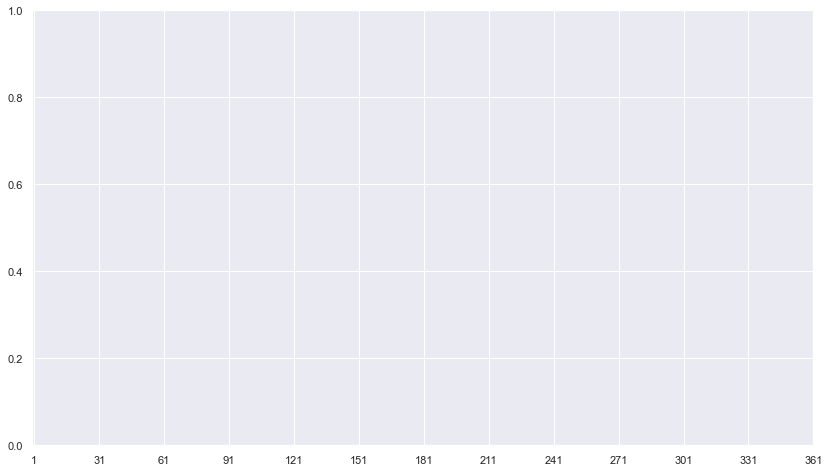

In [75]:
plt.xticks(np.arange(min(df1['dayOfYear']), max(df1['dayOfYear']), 30))

In [76]:
from matplotlib import ticker

In [77]:
# Plotting total consumption

In [78]:
df1.columns

Index(['date2', 'ActualGenerationMW', 'ForecastWind', 'ActualWind',
       'ActualDemand', 'dub_wddir', 'dub_wdsp', 'dub_temp', 'dub_msl',
       'don_wddir', 'don_wdsp', 'don_temp', 'don_msl', 'cla_wddir', 'cla_wdsp',
       'cla_temp', 'cla_msl', 'cor_wddir', 'cor_wdsp', 'cor_temp', 'cor_msl',
       'hour', 'dayOfWeek', 'dayOfYear', 'sin_hour', 'sin_day', 'cos_hour',
       'cos_day', 'sin_dub_wddir', 'cos_dub_wddir', 'sin_cor_wddir',
       'cos_cor_wddir', 'sin_cla_wddir', 'cos_cla_wddir', 'sin_don_wddir',
       'cos_don_wddir', 'cos_dub_vec', 'sin_dub_vec', 'cos_cor_vec',
       'sin_cor_vec', 'cos_cla_vec', 'sin_cla_vec', 'cos_don_vec',
       'sin_don_vec', 'year', 'month', 'totalImbalance', 'totalImbalancep',
       'imbalanceAverage', 'imbalanceVar', 'imbalanceVarAvg'],
      dtype='object')

C:\Users\kevin\AppData\Local\Temp/ipykernel_6268/1770928890.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.unique(months))


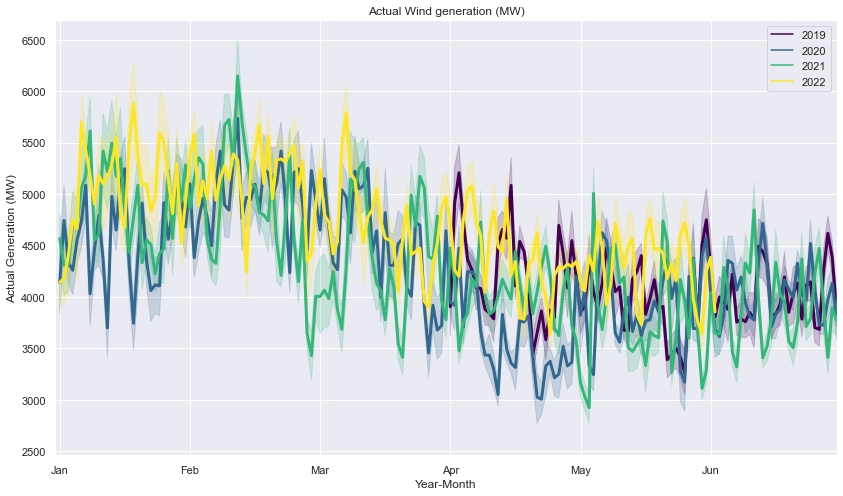

In [79]:
from datetime import datetime

ax = sns.lineplot(data=df1, x ='dayOfYear', y = 'ActualGenerationMW',
                  hue='year', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Actual Generation (MW)')
plt.xlabel('Year-Month')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0, 6, 12, 18]))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0 ]))
plt.title('Actual Wind generation (MW)')
#plt.gcf().autofmt_xdate()
months = list(df1.month)
ax.set_xticklabels(np.unique(months))

plt.xticks(np.arange(1, 360, 30))

#ax.set_xticks(list(range(0,12)))
ax.set_xticklabels([datetime(2017,_,1).strftime('%b') for _ in range(1,13)])
plt.xlim([0, 180])
plt.show()

C:\Users\kevin\AppData\Local\Temp/ipykernel_6268/90417379.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.unique(months))


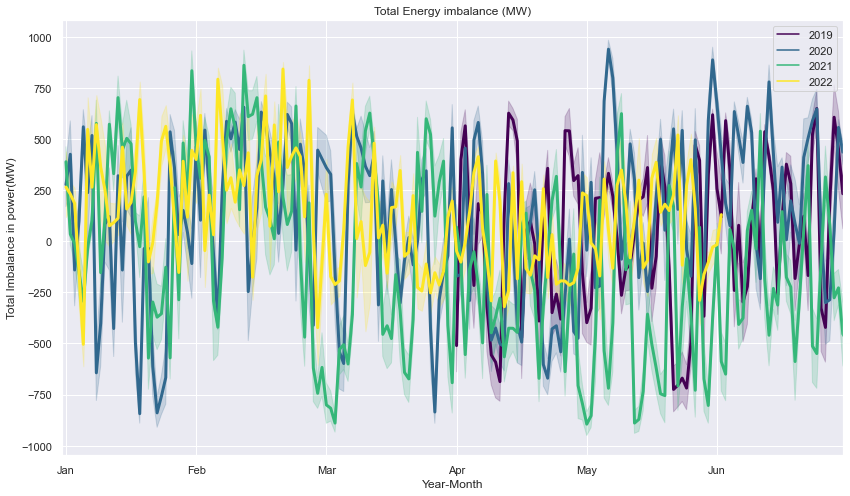

In [80]:
from datetime import datetime

ax = sns.lineplot(data=df1, x ='dayOfYear', y = 'totalImbalance',
                  hue='year', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Total Imbalance in power(MW)')
plt.xlabel('Year-Month')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0, 6, 12, 18]))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0 ]))
plt.title('Total Energy imbalance (MW)')
#plt.gcf().autofmt_xdate()
months = list(df1.month)
ax.set_xticklabels(np.unique(months))

plt.xticks(np.arange(1, 360, 30))

#ax.set_xticks(list(range(0,12)))
ax.set_xticklabels([datetime(2017,_,1).strftime('%b') for _ in range(1,13)])
plt.xlim([0, 180])
plt.show()

C:\Users\kevin\AppData\Local\Temp/ipykernel_6268/2449314769.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.unique(months))


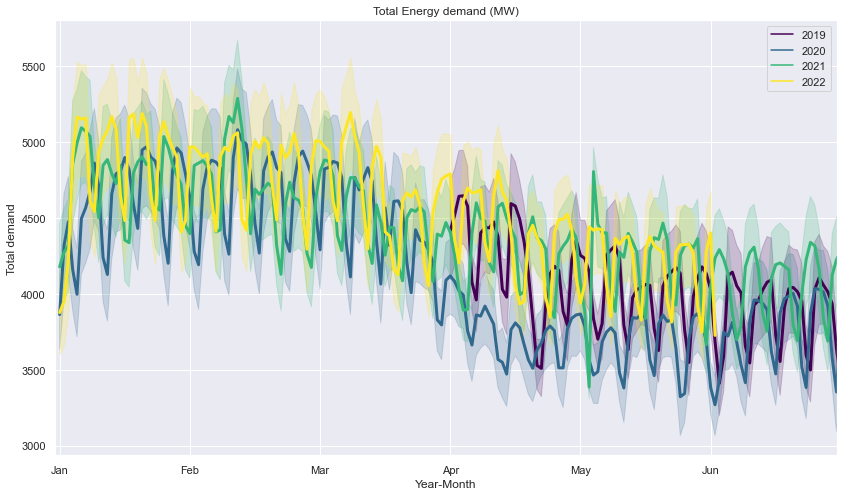

In [81]:
from datetime import datetime

ax = sns.lineplot(data=df1, x ='dayOfYear', y = 'ActualDemand',
                  hue='year', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Total demand')
plt.xlabel('Year-Month')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0, 6, 12, 18]))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0 ]))
plt.title('Total Energy demand (MW)')
#plt.gcf().autofmt_xdate()
months = list(df1.month)
ax.set_xticklabels(np.unique(months))

plt.xticks(np.arange(1, 360, 30))

#ax.set_xticks(list(range(0,12)))
ax.set_xticklabels([datetime(2017,_,1).strftime('%b') for _ in range(1,13)])
plt.xlim([0, 180])
plt.show()

#### Plotting moving average energy imabalance

#####Key dates
12th March 2020 - Lockdown announced
18th May 2020   - Restrictions eased
19th Oct 2020   - Lockdown
1st  Dec 2020   - Eased 
22nd Dec 2020   - Lockdown
28th Feb 2021   - Easing (Eased fully in July)
3rd  Dec 2021   - Lockdown
21st Jan 2022   - Eased



In [82]:
df1['imbalanceAverage'] = df1.totalImbalance.rolling(window=24*14).mean()

C:\Users\kevin\AppData\Local\Temp/ipykernel_6268/3911309778.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.unique(months))


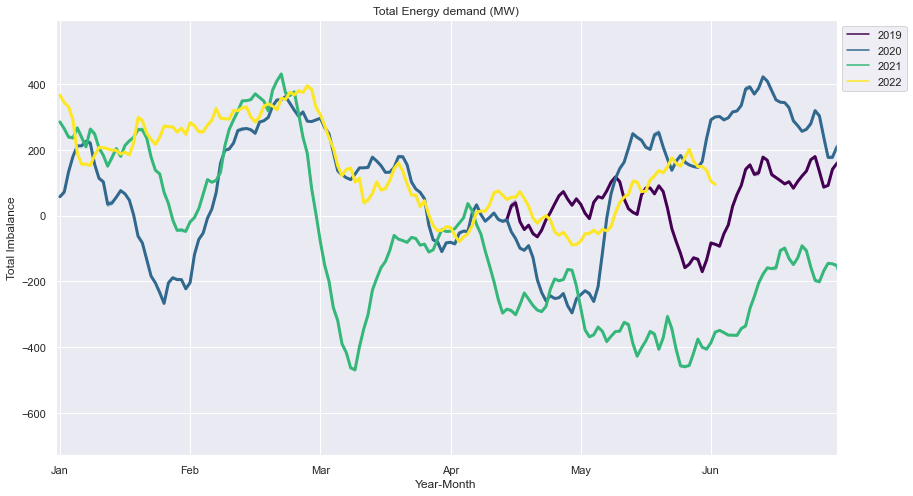

In [83]:
from datetime import datetime

ax = sns.lineplot(data=df1, x ='dayOfYear', y = 'imbalanceAverage',
                  hue='year', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Total Imbalance')
plt.xlabel('Year-Month')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0, 6, 12, 18]))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0 ]))
plt.title('Total Energy demand (MW)')
#plt.gcf().autofmt_xdate()
months = list(df1.month)
ax.set_xticklabels(np.unique(months))

plt.xticks(np.arange(1, 360, 30))

#ax.set_xticks(list(range(0,12)))
ax.set_xticklabels([datetime(2017,_,1).strftime('%b') for _ in range(1,13)])
plt.xlim([0, 180])
plt.show()

#### Calculating the rolling variance of the variables

In [84]:
df1.columns

Index(['date2', 'ActualGenerationMW', 'ForecastWind', 'ActualWind',
       'ActualDemand', 'dub_wddir', 'dub_wdsp', 'dub_temp', 'dub_msl',
       'don_wddir', 'don_wdsp', 'don_temp', 'don_msl', 'cla_wddir', 'cla_wdsp',
       'cla_temp', 'cla_msl', 'cor_wddir', 'cor_wdsp', 'cor_temp', 'cor_msl',
       'hour', 'dayOfWeek', 'dayOfYear', 'sin_hour', 'sin_day', 'cos_hour',
       'cos_day', 'sin_dub_wddir', 'cos_dub_wddir', 'sin_cor_wddir',
       'cos_cor_wddir', 'sin_cla_wddir', 'cos_cla_wddir', 'sin_don_wddir',
       'cos_don_wddir', 'cos_dub_vec', 'sin_dub_vec', 'cos_cor_vec',
       'sin_cor_vec', 'cos_cla_vec', 'sin_cla_vec', 'cos_don_vec',
       'sin_don_vec', 'year', 'month', 'totalImbalance', 'totalImbalancep',
       'imbalanceAverage', 'imbalanceVar', 'imbalanceVarAvg'],
      dtype='object')

In [85]:
df1['imbalanceAverage'] = df1.totalImbalance.rolling(window=24*14).mean()
df1['imbalanceVar']=df1.totalImbalance.rolling(24).var()
df1['imbalanceVarAvg'] = df1.imbalanceVar.rolling(window=24*14).mean()

C:\Users\kevin\AppData\Local\Temp/ipykernel_6268/792869560.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.unique(months))


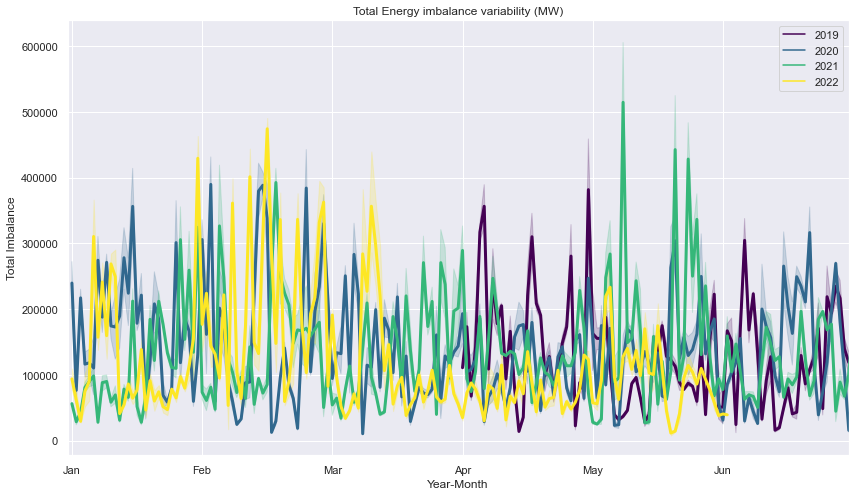

In [86]:
from datetime import datetime

ax = sns.lineplot(data=df1, x ='dayOfYear', y = 'imbalanceVar',
                  hue='year', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Total Imbalance')
plt.xlabel('Year-Month')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0, 6, 12, 18]))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0 ]))
plt.title('Total Energy imbalance variability (MW)')
#plt.gcf().autofmt_xdate()
months = list(df1.month)
ax.set_xticklabels(np.unique(months))

plt.xticks(np.arange(1, 360, 30))

#ax.set_xticks(list(range(0,12)))
ax.set_xticklabels([datetime(2017,_,1).strftime('%b') for _ in range(1,13)])
plt.xlim([0, 180])
plt.show()

In [87]:
df1['imbalanceVarAvg'] = df1.imbalanceVar.rolling(window=24*14).mean()

C:\Users\kevin\AppData\Local\Temp/ipykernel_6268/2339211782.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.unique(months))


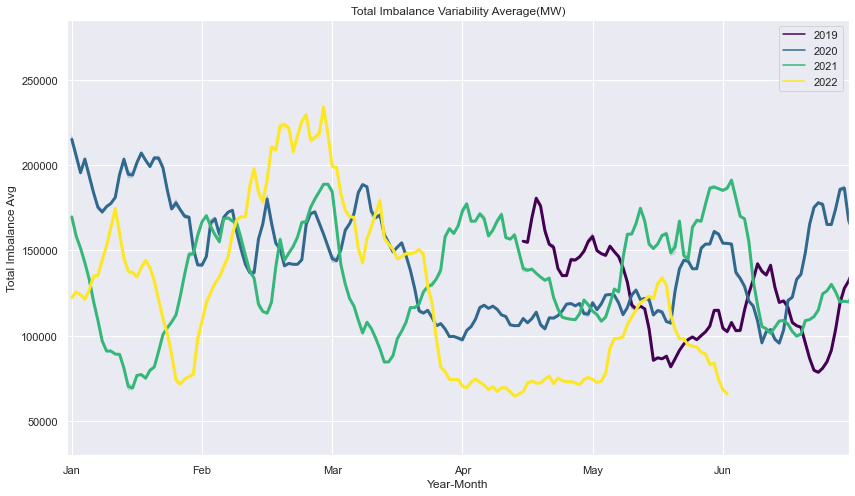

In [88]:
from datetime import datetime

ax = sns.lineplot(data=df1, x ='dayOfYear', y = 'imbalanceVarAvg',
                  hue='year', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Total Imbalance Avg')
plt.xlabel('Year-Month')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0, 6, 12, 18]))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0 ]))
plt.title('Total Imbalance Variability Average(MW)')
#plt.gcf().autofmt_xdate()
months = list(df1.month)
ax.set_xticklabels(np.unique(months))

plt.xticks(np.arange(1, 360, 30))

#ax.set_xticks(list(range(0,12)))
ax.set_xticklabels([datetime(2017,_,1).strftime('%b') for _ in range(1,13)])
plt.xlim([0, 180])
plt.show()

In [89]:
df1.columns

Index(['date2', 'ActualGenerationMW', 'ForecastWind', 'ActualWind',
       'ActualDemand', 'dub_wddir', 'dub_wdsp', 'dub_temp', 'dub_msl',
       'don_wddir', 'don_wdsp', 'don_temp', 'don_msl', 'cla_wddir', 'cla_wdsp',
       'cla_temp', 'cla_msl', 'cor_wddir', 'cor_wdsp', 'cor_temp', 'cor_msl',
       'hour', 'dayOfWeek', 'dayOfYear', 'sin_hour', 'sin_day', 'cos_hour',
       'cos_day', 'sin_dub_wddir', 'cos_dub_wddir', 'sin_cor_wddir',
       'cos_cor_wddir', 'sin_cla_wddir', 'cos_cla_wddir', 'sin_don_wddir',
       'cos_don_wddir', 'cos_dub_vec', 'sin_dub_vec', 'cos_cor_vec',
       'sin_cor_vec', 'cos_cla_vec', 'sin_cla_vec', 'cos_don_vec',
       'sin_don_vec', 'year', 'month', 'totalImbalance', 'totalImbalancep',
       'imbalanceAverage', 'imbalanceVar', 'imbalanceVarAvg'],
      dtype='object')

In [90]:
df1['ActualDemandAvg'] = df1.ActualDemand.rolling(window=24*14).mean()

C:\Users\kevin\AppData\Local\Temp/ipykernel_6268/3220142987.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.unique(months))


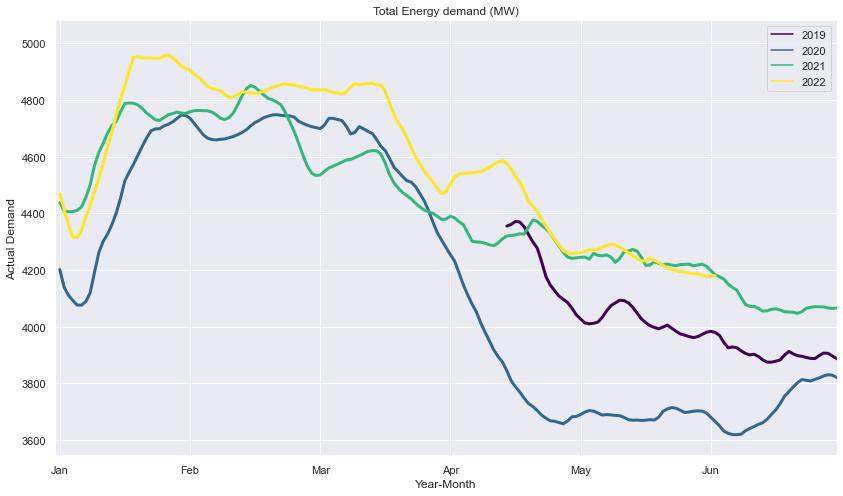

In [91]:
from datetime import datetime

ax = sns.lineplot(data=df1, x ='dayOfYear', y = 'ActualDemandAvg',
                  hue='year', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Actual Demand')
plt.xlabel('Year-Month')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0, 6, 12, 18]))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0 ]))
plt.title('Total Energy demand (MW)')
#plt.gcf().autofmt_xdate()
months = list(df1.month)
ax.set_xticklabels(np.unique(months))

plt.xticks(np.arange(1, 360, 30))

#ax.set_xticks(list(range(0,12)))
ax.set_xticklabels([datetime(2017,_,1).strftime('%b') for _ in range(1,13)])
plt.xlim([0, 180])
plt.show()

C:\Users\kevin\AppData\Local\Temp/ipykernel_6268/2535894946.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.unique(months))


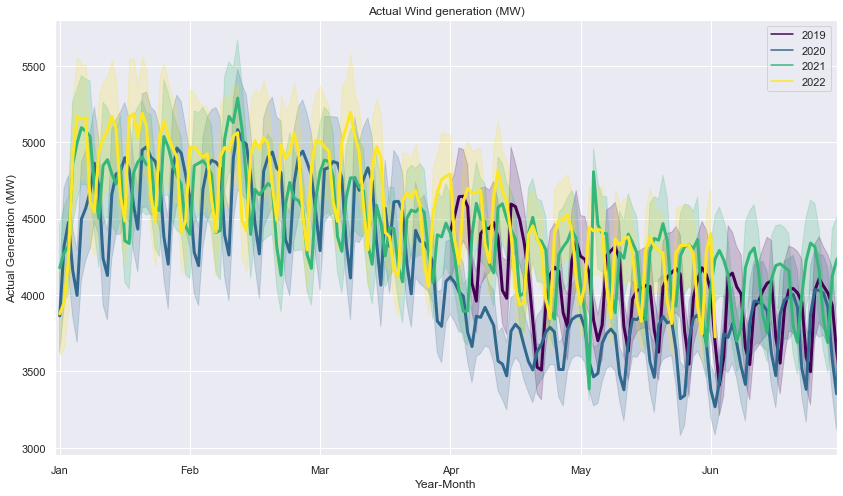

In [93]:
from datetime import datetime
ax = sns.lineplot(data=df1, x ='dayOfYear', y = 'ActualDemand',
                  hue='year', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Actual Generation (MW)')
plt.xlabel('Year-Month')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0, 6, 12, 18]))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0 ]))
plt.title('Actual Wind generation (MW)')
#plt.gcf().autofmt_xdate()
months = list(df1.month)
ax.set_xticklabels(np.unique(months))

plt.xticks(np.arange(1, 360, 30))

#ax.set_xticks(list(range(0,12)))
ax.set_xticklabels([datetime(2017,_,1).strftime('%b') for _ in range(1,13)])
plt.xlim([0, 180])
plt.show()

In [ ]:
from datetime import datetime
ax = sns.lineplot(data=df1, x ='dayOfYear', y = 'ForecastWind',
                  hue='year', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Actual Generation (MW)')
plt.xlabel('Year-Month')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0, 6, 12, 18]))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0 ]))
plt.title('Actual Wind generation (MW)')
#plt.gcf().autofmt_xdate()
months = list(df1.month)
ax.set_xticklabels(np.unique(months))

plt.xticks(np.arange(1, 360, 30))

#ax.set_xticks(list(range(0,12)))
ax.set_xticklabels([datetime(2017,_,1).strftime('%b') for _ in range(1,13)])
plt.xlim([0, 180])
plt.show()

In [ ]:
from datetime import datetime
ax = sns.lineplot(data=df1, x ='dayOfYear', y = 'ActualDemand',
                  hue='year', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Actual Generation (MW)')
plt.xlabel('Year-Month')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0, 6, 12, 18]))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0 ]))
plt.title('Actual Wind generation (MW)')
#plt.gcf().autofmt_xdate()
months = list(df1.month)
ax.set_xticklabels(np.unique(months))

plt.xticks(np.arange(1, 360, 30))

#ax.set_xticks(list(range(0,12)))
ax.set_xticklabels([datetime(2017,_,1).strftime('%b') for _ in range(1,13)])
plt.xlim([0, 180])
plt.show()

In [ ]:
import plotly.graph_objects as go

#extract color palette, the palette can be changed
pal = list(sns.color_palette(palette='viridis', n_colors=len(months)).as_hex())

fig = go.Figure()

In [ ]:

for d,p in zip(months, pal):
    fig.add_trace(go.Scatter(x = df1[df1['month']==d]['dayOfYear'],
                             y = df1[df1['month']==d]['ActualDemand'],
                             name = d,
                             line_color = p, 
                             fill=None))   #tozeroy 

fig.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

### Correlation between the price of electricity and the supply demand differential

### Splitting the data

In [ ]:
print(df1['date2'].dt.strftime("%m/%y").drop_duplicates().tolist())

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

splitOption = 1 # split per day of the month


testSet = dataSet.loc[(inData.date > cutOffTestDate), :]
mainSet = dataSet.loc[(inData.date <= cutOffTestDate), :]

if (splitOption == 0):  # Standard SkLearn train test split, usually not good for time series
  trainSet, validSet = train_test_split(mainSet, test_size=0.2, random_state=42)
elif (splitOption == 1):  # split before / after day of the month
  dataSet["dayInMonth"] = 0

  def setDayInMonth(row):
      row["dayInMonth"] = row.date.day
      return row

  dataSet = dataSet.apply(setDayInMonth, axis=1)

  trainSet = dataSet.loc[(dataSet.dayInMonth > 0) & (dataSet.dayInMonth < 23), :]
  validSet = dataSet.loc[(dataSet.dayInMonth >= 23) & (inData.date <= cutOffTestDate), :]
elif (splitOption == 2):  # split per period
  trainSet = dataSet.loc[(inData.date <= cutOffValidationDate), :]
  validSet = dataSet.loc[(inData.date > cutOffValidationDate), :]  


y_train = trainSet.ActualWindMW
y_valid = validSet.ActualWindMW
y_test = testSet.ActualWindMW

### Random Forest Model <a name="forest"></a>

In [ ]:
df1

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

splitOption = 1 # split per day of the month


testSet = dataSet.loc[(inData.date > cutOffTestDate), :]
mainSet = dataSet.loc[(inData.date <= cutOffTestDate), :]

if (splitOption == 0):  # Standard SkLearn train test split, usually not good for time series
  trainSet, validSet = train_test_split(mainSet, test_size=0.2, random_state=42)
elif (splitOption == 1):  # split before / after day of the month
  dataSet["dayInMonth"] = 0

  def setDayInMonth(row):
      row["dayInMonth"] = row.date.day
      return row

  dataSet = dataSet.apply(setDayInMonth, axis=1)

  trainSet = dataSet.loc[(dataSet.dayInMonth > 0) & (dataSet.dayInMonth < 23), :]
  validSet = dataSet.loc[(dataSet.dayInMonth >= 23) & (inData.date <= cutOffTestDate), :]
elif (splitOption == 2):  # split per period
  trainSet = dataSet.loc[(inData.date <= cutOffValidationDate), :]
  validSet = dataSet.loc[(inData.date > cutOffValidationDate), :]  


y_train = trainSet.ActualWindMW
y_valid = validSet.ActualWindMW
y_test = testSet.ActualWindMW

### 